## Project: Plant Seedlings

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained model based on the VGG16 model.

Used Dataset from: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset

The model is trained on food images to distinguish plant seeds divided in 12 classes: Black Grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen, Loose Silky Bent, Maize, Scentless Mayweed, Shepherd Purse, Small flowered Cranesbill, and Sugar Beet.

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [5]:
!python3 --version

Python 3.11.9


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

In [6]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [8]:
#from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Shuffle images from directory into train, valid, and test sets

In [9]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [10]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        
                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True, 
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)), 
                                               shuffle=True,random_state=rs)
        
                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [11]:
# Print the count of items from each class

count = 0
for folder in os.listdir(main_dir):
    folder_pics = len(os.listdir(os.path.join(main_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The Shepherd_Purse class has 274 pictures.
The Cleavers class has 335 pictures.
The Loose_Silky-bent class has 762 pictures.
The Common_Chickweed class has 713 pictures.
The Scentless_Mayweed class has 607 pictures.
The Sugar_beet class has 463 pictures.
The Black-grass class has 309 pictures.
The Fat_Hen class has 538 pictures.
The Small-flowered_Cranesbill class has 576 pictures.
The Common_wheat class has 253 pictures.
The Charlock class has 452 pictures.
The Maize class has 257 pictures.
5539 total images


## Let us have a look at the classes we are going to classify

In [12]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(main_dir):
    pics = random.choice(os.listdir(os.path.join(main_dir, folder)))
    path_pic = os.path.join(main_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

print(image_examples_dict)

{'Shepherd_Purse': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Shepherd_Purse/211.png', 'Cleavers': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Cleavers/229.png', 'Loose_Silky-bent': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Loose_Silky-bent/351.png', 'Common_Chickweed': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Common_Chickweed/662.png', 'Scentless_Mayweed': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Scentless_Mayweed/529.png', 'Sugar_beet': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Sugar_beet/459.png', 'Black-grass': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Black-grass/115.png', 'Fat_Hen': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Fat_Hen/166.png', 'Small-flowered_Cranesbill': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Small-flowered_Cranesbill/231.png', 'Common_wheat': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Common_wheat/74.png', 'Charlock': '/User

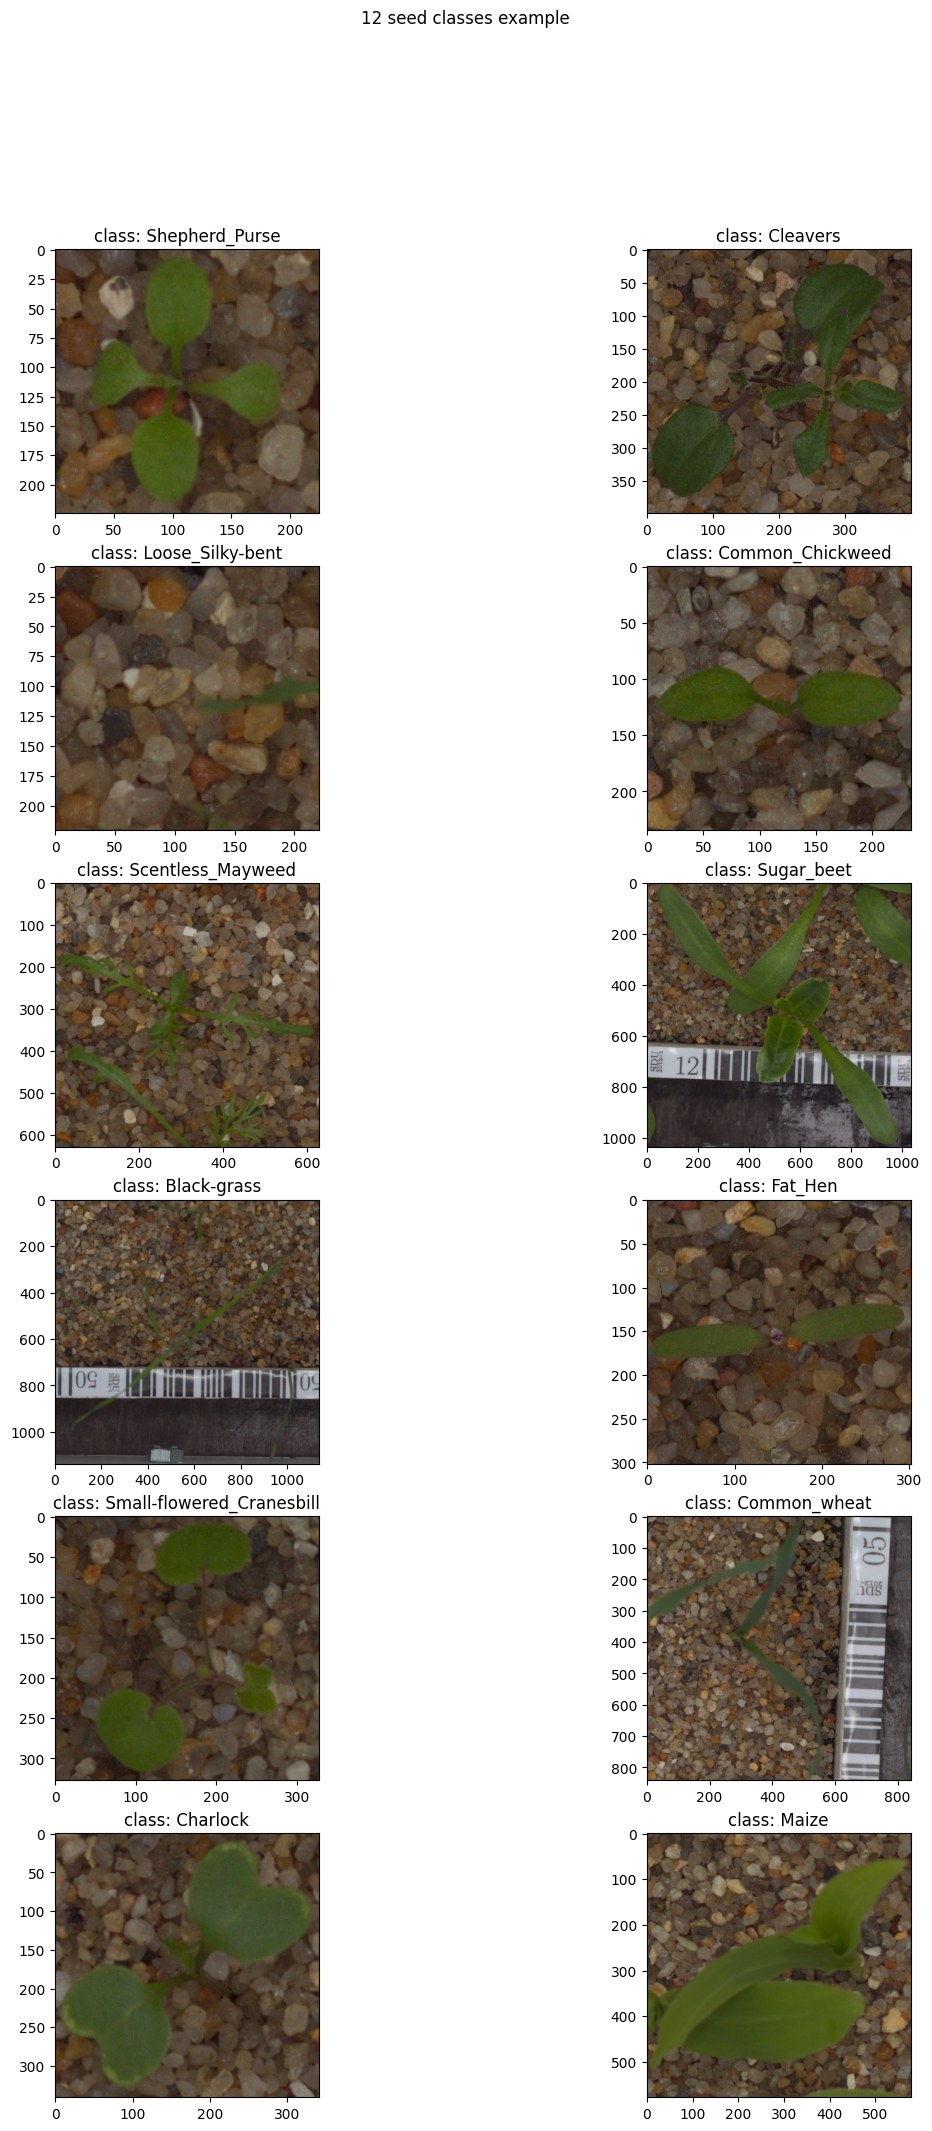

In [13]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(14, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('12 seed classes example')
plt.show()

## Model definition


In [14]:
# here I define some important parameter that are going to be used in both models

#num_classes = 12

image_resize = 224

batch_size_training = 32
batch_size_validation = 32

num_epochs = 8

In [15]:
# instantiate the image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Now we can generate train and validation set with ImageDataGenerator

In [16]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

Found 3872 images belonging to 12 classes.


In [17]:
validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
)

Found 830 images belonging to 12 classes.


In [18]:
num_classes = train_generator.num_classes

In [19]:
class_names = {y: x for x, y in validation_generator.class_indices.items()}
class_names

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherd_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

Here we define some optimization parameters that are going to be used with both models.

In [20]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

print(steps_per_epoch_training,steps_per_epoch_validation)

121 26


## Build the model

### we start with the tailored-made CNN model

In [21]:

def get_model_cnn():
	input = Input(shape=(image_resize,image_resize,3,)) # (None, 224, 224, 3)
	
	conv1  = Conv2D(32,(2,2),activation='relu',padding="same")(input) 
	conv12 = Conv2D(32,(2,2),activation='relu',padding="same")(conv1) 
	pool1  = MaxPooling2D(pool_size=(2,2))(conv12) 
	
	conv2  = Conv2D(64,(3,3),activation='relu',padding="same")(pool1) 
	conv22 = Conv2D(64,(3,3),activation='relu',padding="same")(conv2) 
	pool2  = MaxPooling2D(pool_size=(2,2))(conv22) 
	
	conv3 = Conv2D(128,(3,3),activation='relu',padding="same")(pool2) 
	conv32 = Conv2D(128,(3,3),activation='relu',padding="same")(conv3) 
	pool3 = MaxPooling2D(pool_size=(2,2))(conv32)
	
	conv4 = Conv2D(256,(3,3),activation='relu')(pool3)
	pool4 = MaxPooling2D(pool_size=(3,3))(conv4)

	conv5 = Conv2D(256,(3,3),activation='relu')(pool4)
	pool5 = MaxPooling2D(pool_size=(3,3))(conv5) 
	
	flat = Flatten()(pool5) 
	
	drop = Dropout(0.3)(flat) 
	fully1 = Dense(512, activation='relu')(drop)  # (None, 512)
	drop1 = Dropout(0.3)(fully1) 
	fully2 = Dense(512, activation='relu')(drop1) # (None, 512)
	
	pred = Dense(num_classes, activation='softmax')(fully2) # (None, 12)
	
	model = Model(inputs=input, outputs=pred)
	
	model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
	
	return model



In [22]:
model_cnn = get_model_cnn()

model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,960,268 (7.48 MB)

 Trainable params: 1,960,268 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_cnn.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <Conv2D name=conv2d_5, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Conv2D name=conv2d_6, built=True>,
 <MaxPooling2D name=max_pooling2d_3, built=True>,
 <Conv2D name=conv2d_7, built=True>,
 <MaxPooling2D name=max_pooling2d_4, built=True>,
 <Flatten name=flatten, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [19]:
%%time
start_datetime = datetime.now()

fit_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
121/121 [==============================] - 131s 1s/step - loss: 2.4296 - accuracy: 0.1418 - val_loss: 2.0192 - val_accuracy: 0.2747
Epoch 2/8
121/121 [==============================] - 133s 1s/step - loss: 1.8362 - accuracy: 0.3461 - val_loss: 1.4584 - val_accuracy: 0.4602
Epoch 3/8
121/121 [==============================] - 135s 1s/step - loss: 1.3353 - accuracy: 0.5168 - val_loss: 1.1478 - val_accuracy: 0.5651
Epoch 4/8
121/121 [==============================] - 136s 1s/step - loss: 1.0567 - accuracy: 0.6157 - val_loss: 0.8763 - val_accuracy: 0.6795
Epoch 5/8
121/121 [==============================] - 135s 1s/step - loss: 0.8260 - accuracy: 0.7012 - val_loss: 0.7359 - val_accuracy: 0.7434
Epoch 6/8
121/121 [==============================] - 134s 1s/step - loss: 0.6507 - accuracy: 0.7647 - val_loss: 0.6462 - val_accuracy: 0.7795
Epoch 7/8
121/121 [==============================] - 134s 1s/step - loss: 0.5532 - accuracy: 0.8037 - val_loss: 0.5990 - val_accuracy: 0.8000
Epoch 

In [20]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "../saved_models"
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")

save_model(model_cnn, "classifier_cnn_model.h5")

model updated


/Users/brncat/Downloads/AltaVerde/GitHub/Plant_Seedlings/notebook/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


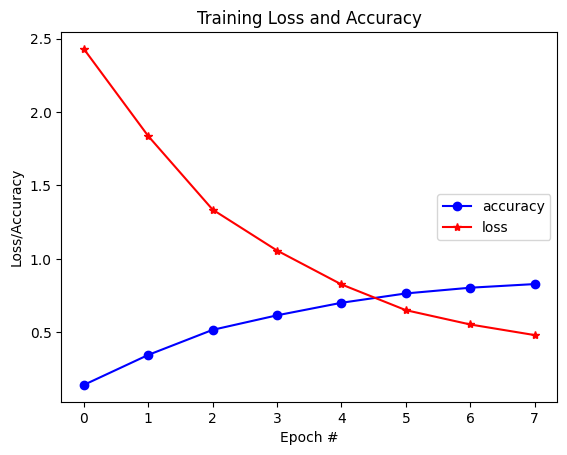

In [21]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# VGG16

## Now that we trained and saved the CNN model, we train a pre-trained model based on the VGG16 model.

In [22]:
def get_model_vgg():

    base_model = VGG16(weights='imagenet', include_top=False) #imports the VGG16 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = keras.layers.GlobalAveragePooling2D()(x) # (None, 512)

    x = Dropout(0.2)(x) # (None, 512)
    x = Dense(256,activation='relu')(x) # (None, 256)
    x = Dropout(0.2)(x) # (None, 256)

    preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
model_vgg = get_model_vgg()

model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [24]:
model_vgg.layers

In [25]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
121/121 [==============================] - 293s 2s/step - loss: 2.3304 - accuracy: 0.3869 - val_loss: 1.0471 - val_accuracy: 0.6940
Epoch 2/8
121/121 [==============================] - 300s 2s/step - loss: 1.1957 - accuracy: 0.6074 - val_loss: 0.7295 - val_accuracy: 0.7735
Epoch 3/8
121/121 [==============================] - 301s 2s/step - loss: 0.9830 - accuracy: 0.6547 - val_loss: 0.6731 - val_accuracy: 0.7892
Epoch 4/8
121/121 [==============================] - 303s 3s/step - loss: 0.8322 - accuracy: 0.7138 - val_loss: 0.5978 - val_accuracy: 0.8108
Epoch 5/8
121/121 [==============================] - 305s 3s/step - loss: 0.7211 - accuracy: 0.7454 - val_loss: 0.5432 - val_accuracy: 0.8193
Epoch 6/8
121/121 [==============================] - 306s 3s/step - loss: 0.6830 - accuracy: 0.7614 - val_loss: 0.5591 - val_accuracy: 0.8145
Epoch 7/8
121/121 [==============================] - 307s 3s/step - loss: 0.6148 - accuracy: 0.7812 - val_loss: 0.5064 - val_accuracy: 0.8289
Epoch 

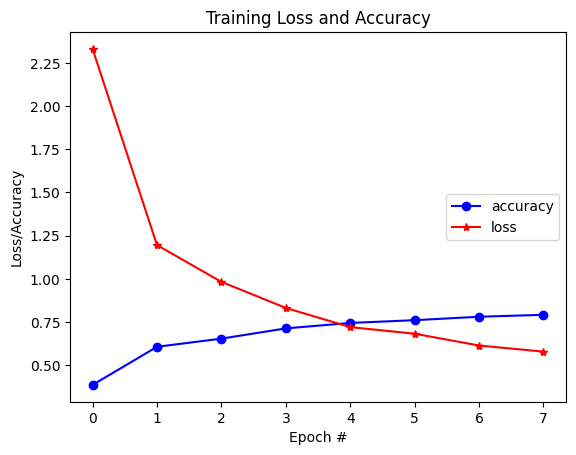

In [26]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [27]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg_model.h5")

model updated


#  Persist the models and evaluate on the test set

In [28]:
# also run the first two cells to define file path and ramdom state 

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import preprocess_input

from keras.models import load_model

In this step we load the saved models and evaluate them on the test set

In [29]:
!ls 

notebook.ipynb   requirements.txt


In [30]:
# instantiate image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

image_resize = 224

test_dir = os.path.join(file_path,'test')

#check existence of the path
if os.path.isdir(test_dir):
    print("test set found!")
else:
    raise Exception("test set directory not found!")

True

In [31]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
)

Found 837 images belonging to 12 classes.


In [32]:
print(test_generator.batch_size)

1


In [33]:
class_names = {y: x for x, y in test_generator.class_indices.items()}
class_names

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherd_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

In [34]:
# load the models

model_cnn = load_model('../saved_models/classifier_cnn_model.h5')

model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

In [35]:
# Evaluate CNN on test_generator

test_generator.reset()
eval_cnn = model_cnn.evaluate(test_generator)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

837/837 [==============================] - 14s 16ms/step - loss: 0.4119 - accuracy: 0.8530
CNN Test loss:  0.41187790036201477
CNN Test Accuracy:  0.8530465960502625


In [36]:
# Evaluate pre-trained model on test_generator

test_generator.reset()
eval_vgg = model_vgg.evaluate(test_generator)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

837/837 [==============================] - 66s 79ms/step - loss: 0.4725 - accuracy: 0.8351
VGG Test loss:  0.4725295901298523
VGG Test Accuracy:  0.8351254463195801


## Plot the Confusion Matrix

We can plot the Confusion matrix, but first we redefine the test_generator with batch size equal to the number of images on the test set, which can be accessed by `test_generator.n`

In [37]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = test_generator.n , #The length of the test set to make easy plotting confusion matrix
    class_mode='categorical',
    seed=rs
)

Found 837 images belonging to 12 classes.


In [38]:
print(test_generator.batch_size)

837


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def conf_matrix_plot(model, x_data):
    '''
    Accepts as argument model object, and X data (test or validate) generator. 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    y_data = np.argmax(x_data[0][1],axis=-1)
    model_pred = np.argmax(model.predict(x_data),axis=-1)
    cm = confusion_matrix(y_data, model_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  
    disp.plot()
    plt.show()


1/1 [==============================] - 15s 15s/step


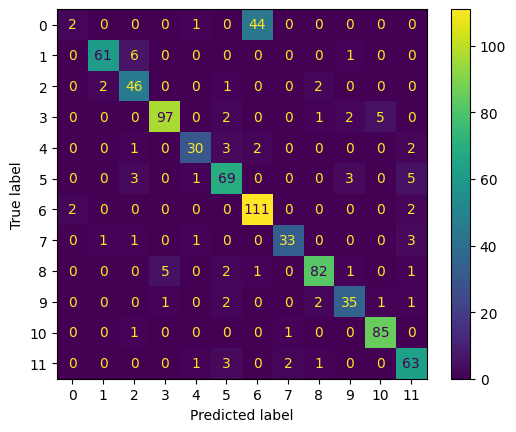

In [40]:
conf_matrix_plot(model_cnn, test_generator)

1/1 [==============================] - 111s 111s/step


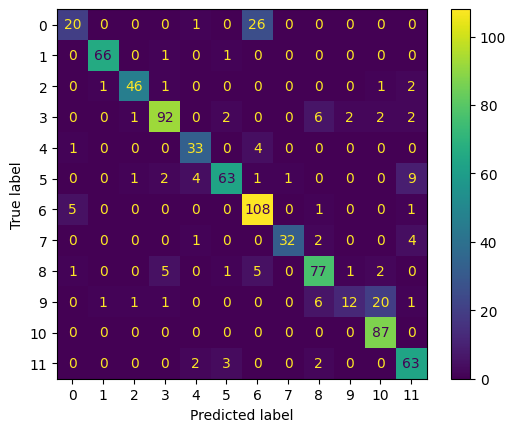

In [41]:
conf_matrix_plot(model_vgg, test_generator)

### We see that the VGG16 pre-trained model performs better than our defined CNN model.

Although the VGG16 model performs slightly better than our CNN model on the test set, we prefer our CNN due to its shorter training time and smaller size.